In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import process_time

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Change current work directory
#%pwd
#%cd "Week 20/Capstone"

## Read Data

In [3]:
#Read in the data file
df = pd.read_csv('data/diabetic_data.csv', sep = ',')

## Data Exploration and Cleaning

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
df.shape

(101766, 50)

In [6]:
#Replace "?" with nan
df1 = df.replace("?", np.nan)

In [7]:
df1.isna().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

#### Distribution by Gender

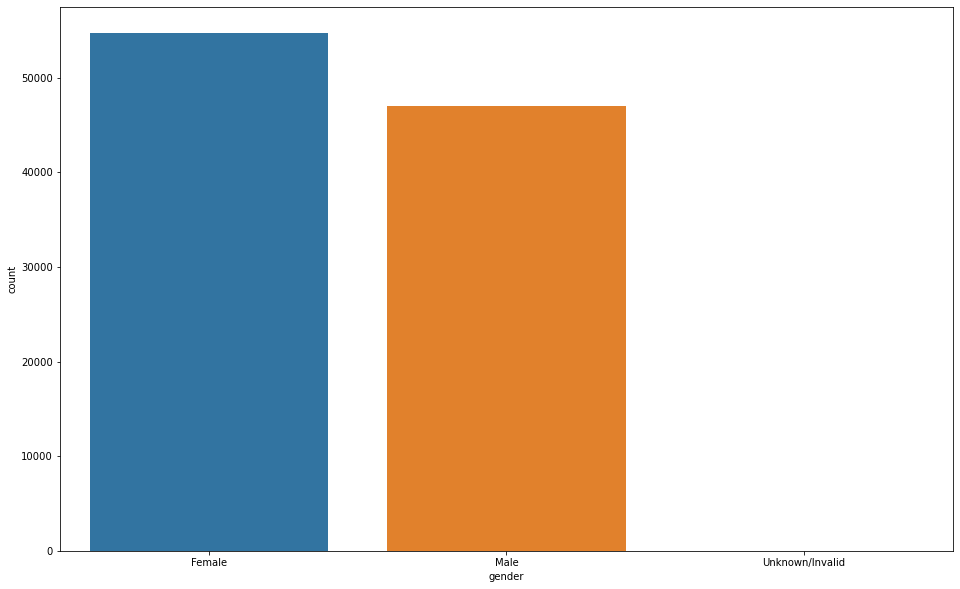

In [8]:
plt.subplots(figsize=(16,10))
sns.countplot(data=df, x='gender')
plt.show()

#### Distribution by Age

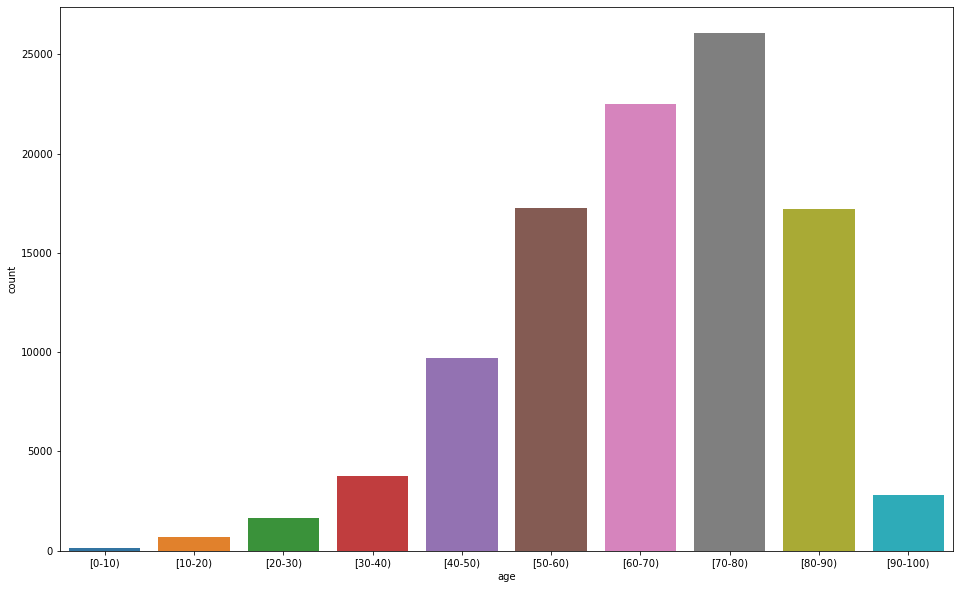

In [9]:
plt.subplots(figsize=(16,10))
sns.countplot(data=df, x='age')
plt.show()

### Data Cleaning

In [10]:
#Drop encounter id as it is unique patient encounter per row
df1 = df1.drop(['encounter_id'], axis = 1)

In [11]:
#Drop patient number too although a patient can have multiple encounters; as other features can identify unique patients somewhat
df1 = df1.drop(['patient_nbr'], axis = 1)

In [12]:
#Drop columns with about 50% missing data
df1 = df1.drop(['weight', 'payer_code', 'medical_specialty'], axis = 1)

In [13]:
#Drop because values are always the same
df1 = df1.drop(['citoglipton', 'examide'], axis = 1)

In [14]:
#Replace missing age with mean - not needed as all values populated
#df1['age'].fillna((df1['age'].mean()), inplace=True)

#Replace all other missing values with most frequent values
df1 = df1.fillna(df1.mode().iloc[0])

In [15]:
df1.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [16]:
df1.max_glu_serum.value_counts(normalize= True)

None    0.947468
Norm    0.025519
>200    0.014592
>300    0.012421
Name: max_glu_serum, dtype: float64

In [17]:
df1['gender'] = df1['gender'].replace(['Male','Female','Unknown/Invalid'], [0,1,2])

In [18]:
df1['race'] = df1['race'].replace(['Caucasian','AfricanAmerican','Hispanic','Asian','Other'], [0,1,2,3,4])

In [19]:
df1['age'] = df1['age'].map({'[0-10)': 0,'[10-20)' : 1,'[20-30)' : 2, '[30-40)' : 3, '[40-50)' : 4, '[50-60)' : 5,
                             '[60-70)' : 6, '[70-80)' : 7, '[80-90)' : 8, '[90-100)' : 9})

In [20]:
df1['change'] = df1['change'].replace(['Ch','No'], [1,0])
df1['diabetesMed'] = df1['diabetesMed'].replace(['Yes','No'], [1,0])

In [21]:
df1['A1Cresult'] = df1['A1Cresult'].replace(['None','Norm','>7','>8'], [-1,0,1,1])

In [22]:
df1['max_glu_serum'] = df1['max_glu_serum'].replace(['None','Norm','>200','>300'], [-1,0,1,1])

In [23]:
df1['readmitted'] = df1['readmitted'].replace(['NO','<30','>30'], [0,1,2])

In [24]:
#Drop individual medicine flags as there is a diabetesMed field that tracks if patient is taking med
medicine = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
        'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 
        'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone',
        'metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin',
        'troglitazone', 'tolbutamide', 'acetohexamide']

In [25]:
df1 = df1.drop(medicine, axis = 1)

In [26]:
#Drop specific diagnoses column and keep number of diagnoeses column
df1 = df1.drop(['diag_1','diag_2','diag_3'], axis = 1)

### Correlation of numeric variables

In [27]:
df1.corr()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted
race,1.000000,0.030957,-0.135408,-0.036385,-0.009651,-0.007198,-0.003503,0.011833,-0.014777,-0.054676,-0.042413,0.021569,-0.002449,-0.075796,-0.026021,0.032618,0.009990,0.005056,-0.024551
gender,0.030957,1.000000,0.050600,-0.014636,0.020991,0.003810,0.029866,0.003021,-0.059843,0.022030,0.011430,0.021043,0.014554,0.003277,0.002473,-0.022761,-0.014832,-0.015945,0.018373
age,-0.135408,0.050600,1.000000,-0.007209,0.114323,0.044696,0.107515,0.020770,-0.030104,0.041847,0.023724,-0.087291,-0.042861,0.242597,0.029727,-0.128407,-0.036019,-0.022601,0.026816
admission_type_id,-0.036385,-0.014636,-0.007209,1.000000,0.083483,0.106654,-0.012500,-0.143713,0.129888,0.079535,0.026511,-0.019116,-0.038161,-0.117126,0.382406,-0.046977,0.007274,-0.000310,-0.001342
discharge_disposition_id,-0.009651,0.020991,0.114323,0.083483,1.000000,0.018193,0.162748,0.023415,0.015921,0.108753,-0.008715,-0.024471,0.020787,0.046891,0.044663,-0.021016,-0.012307,-0.028887,-0.033281
admission_source_id,-0.007198,0.003810,0.044696,0.106654,0.018193,1.000000,-0.006965,0.048885,-0.135400,-0.054533,0.027244,0.059892,0.036314,0.072114,0.444999,0.003318,0.002435,0.001500,0.041193
time_in_hospital,-0.003503,0.029866,0.107515,-0.012500,0.162748,-0.006965,1.000000,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,0.220186,0.022651,0.060527,0.109173,0.062520,0.040309
num_lab_procedures,0.011833,0.003021,0.020770,-0.143713,0.023415,0.048885,0.318450,1.000000,0.058066,0.268161,-0.007602,-0.002279,0.039231,0.152773,-0.144569,0.246460,0.063958,0.033107,0.035441
num_procedures,-0.014777,-0.059843,-0.030104,0.129888,0.015921,-0.135400,0.191472,0.058066,1.000000,0.385767,-0.024819,-0.038179,-0.066236,0.073734,-0.073352,-0.011813,0.004448,-0.006821,-0.044150
num_medications,-0.054676,0.022030,0.041847,0.079535,0.108753,-0.054533,0.466135,0.268161,0.385767,1.000000,0.045197,0.013180,0.064194,0.261526,-0.005860,0.018510,0.246846,0.186910,0.037399


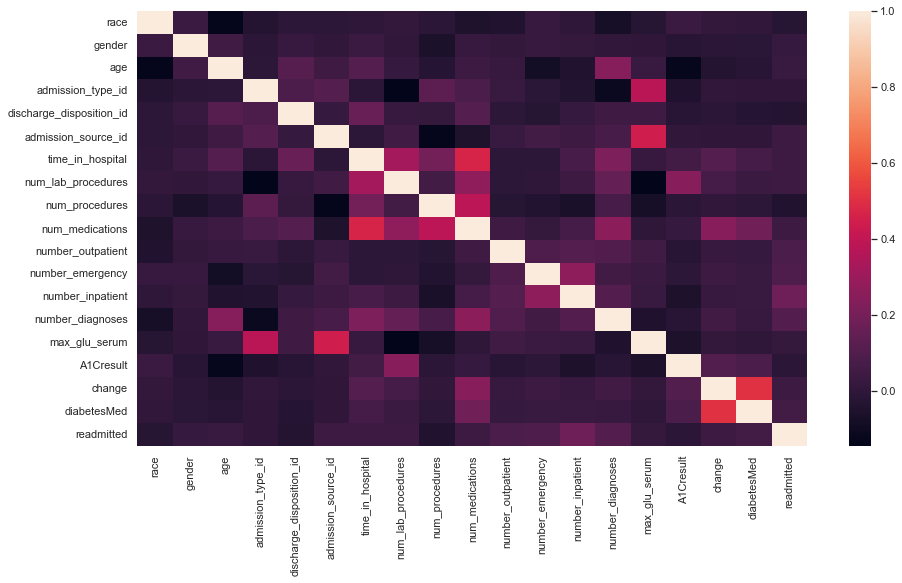

In [28]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(df1.corr())

### Check if output class is imbalanced

In [29]:
df1.readmitted.value_counts(normalize= True)

0    0.539119
2    0.349282
1    0.111599
Name: readmitted, dtype: float64

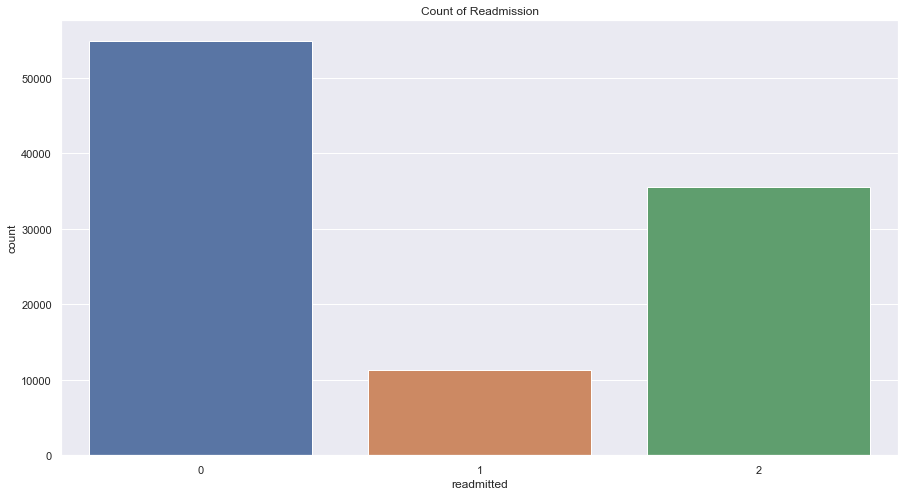

In [30]:
ax = sns.countplot(x="readmitted", data=df1).set(title = 'Count of Readmission')

We see that about 53% do not get readmitted; about 35% get admitted in >30 days and about 11% get admitted in <30 days.

### Redefine output to 2 classes only (readmitted or not regardless of number of days)

In [31]:
df1['y'] = df1['readmitted'].replace([0,1,2], [0,1,1])

In [32]:
df1.y.value_counts(normalize= True)

0    0.539119
1    0.460881
Name: y, dtype: float64

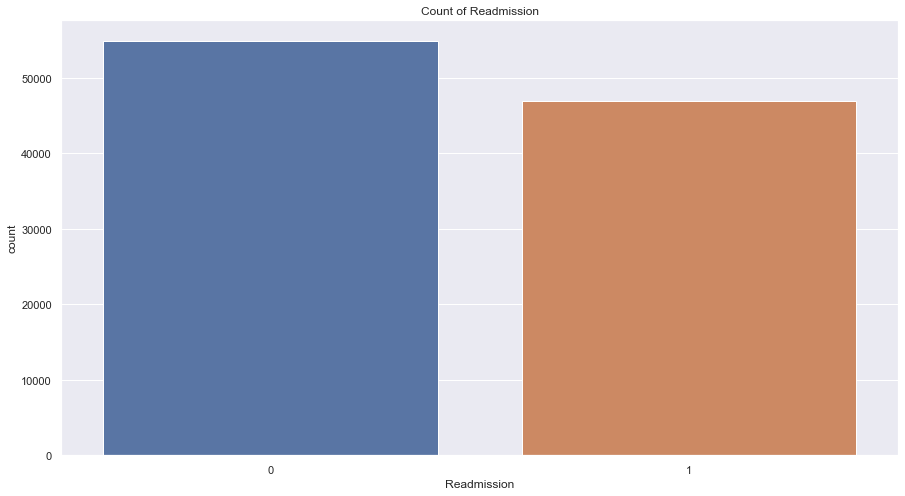

In [33]:
ax = sns.countplot(x="y", data=df1).set(title = 'Count of Readmission', xlabel = "Readmission")

We see the output class is balanced.

We will use this redefined definition of readmission in our model.

In [34]:
#Drop output that has different class for admitted <30 and >30 days 
df1 = df1.drop(['readmitted'], axis = 1)

In [35]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   race                      101766 non-null  int64
 1   gender                    101766 non-null  int64
 2   age                       101766 non-null  int64
 3   admission_type_id         101766 non-null  int64
 4   discharge_disposition_id  101766 non-null  int64
 5   admission_source_id       101766 non-null  int64
 6   time_in_hospital          101766 non-null  int64
 7   num_lab_procedures        101766 non-null  int64
 8   num_procedures            101766 non-null  int64
 9   num_medications           101766 non-null  int64
 10  number_outpatient         101766 non-null  int64
 11  number_emergency          101766 non-null  int64
 12  number_inpatient          101766 non-null  int64
 13  number_diagnoses          101766 non-null  int64
 14  max_glu_serum       

### Encoder and Transform Data

We will use Standard Scaler transformation with all our models. ALl encoding is already handled in the data cleaning.

In [36]:
#Create transformer - use standard scaling. Encoding is already handled upstream in data cleaning

#transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['insulin']),
#                                     remainder = StandardScaler())

### Train / Test Split

In [37]:
X = df1.drop(['y'], axis = 1)

In [38]:
y = df1.y

In [39]:
#split to train and test - no need to use stratify=y as data is balanced
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = .3, random_state = 42)

## Baseline Model

We run dummy classifier on the entire data (X and y). 
The input feature values are ignored so encoding/transformation is not necessary.

In [40]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)

DummyClassifier(strategy='most_frequent')

In [41]:
dummy_clf.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [42]:
dummy_clf.score(X,y)

0.5391191557101586

Our model needs to beat this benchmark.

## Simple Model

### Logistic Regression

In [43]:
lr_start = process_time()
lr_pipe = Pipeline([('transform', StandardScaler()), ('lr', LogisticRegression())])
lr_pipe.fit(X_train, y_train)
lr_stop = process_time()
lr_pipe

Pipeline(steps=[('transform', StandardScaler()), ('lr', LogisticRegression())])

#### Scoring the first simple model

In [44]:
lr_train_acc = lr_pipe.score(X_train, y_train)
lr_test_acc = lr_pipe.score(X_test, y_test)
lr_predictions = lr_pipe.predict(X_test)
lr_time = lr_stop-lr_start

### Results
print(classification_report(lr_predictions, y_test))

print(f'Training Accuracy : {lr_train_acc: .2f}')
print(f'Test Accuracy     : {lr_test_acc: .8f}')
print(f'Train Time        : {lr_time}')

              precision    recall  f1-score   support

           0       0.81      0.61      0.70     21678
           1       0.40      0.64      0.49      8852

    accuracy                           0.62     30530
   macro avg       0.60      0.62      0.59     30530
weighted avg       0.69      0.62      0.64     30530

Training Accuracy :  0.62
Test Accuracy     :  0.61909597
Train Time        : 0.34375


This model outperforms our benchmark model but we will explore some addtional basic models with default parameters first and compare their results.

### KNN

In [45]:
knn_start = process_time()
knn_pipe = Pipeline([('transform', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_pipe.fit(X_train, y_train)
knn_stop = process_time()
knn_pipe

Pipeline(steps=[('transform', StandardScaler()),
                ('knn', KNeighborsClassifier())])

In [46]:
knn_train_acc = knn_pipe.score(X_train, y_train)
knn_test_acc = knn_pipe.score(X_test, y_test)
knn_predictions = knn_pipe.predict(X_test)
knn_time = knn_stop-knn_start

### Results
print(classification_report(knn_predictions, y_test))

print(f'Training Accuracy : {knn_train_acc: .2f}')
print(f'Test Accuracy     : {knn_test_acc: .8f}')
print(f'Train Time        : {knn_time}')

              precision    recall  f1-score   support

           0       0.65      0.61      0.63     17626
           1       0.51      0.55      0.53     12904

    accuracy                           0.59     30530
   macro avg       0.58      0.58      0.58     30530
weighted avg       0.59      0.59      0.59     30530

Training Accuracy :  0.73
Test Accuracy     :  0.58503112
Train Time        : 0.03125


### Decision Tree

In [47]:
dt_start = process_time()
dt_pipe = Pipeline([('transform', StandardScaler()), ('dt', DecisionTreeClassifier(random_state=42))])
dt_pipe.fit(X_train, y_train)
dt_stop = process_time()
dt_pipe

Pipeline(steps=[('transform', StandardScaler()),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [48]:
dt_train_acc = dt_pipe.score(X_train, y_train)
dt_test_acc = dt_pipe.score(X_test, y_test)
dt_predictions = dt_pipe.predict(X_test)
dt_time = dt_stop-dt_start

### Results
print(classification_report(dt_predictions, y_test))

print(f'Training Accuracy : {dt_train_acc: .2f}')
print(f'Test Accuracy     : {dt_test_acc: .8f}')
print(f'Train Time        : {dt_time}')

              precision    recall  f1-score   support

           0       0.59      0.59      0.59     16266
           1       0.53      0.52      0.53     14264

    accuracy                           0.56     30530
   macro avg       0.56      0.56      0.56     30530
weighted avg       0.56      0.56      0.56     30530

Training Accuracy :  1.00
Test Accuracy     :  0.56105470
Train Time        : 0.46875


### SVM

In [49]:
svc_start = process_time()
svc_pipe = Pipeline([('transform', StandardScaler()), ('svc', SVC())])
svc_pipe.fit(X_train, y_train)
svc_stop = process_time()
svc_pipe

Pipeline(steps=[('transform', StandardScaler()), ('svc', SVC())])

In [50]:
svc_train_acc = svc_pipe.score(X_train, y_train)
svc_test_acc = svc_pipe.score(X_test, y_test)
svc_predictions = svc_pipe.predict(X_test)
svc_time = svc_stop-dt_start

### Results
print(classification_report(svc_predictions, y_test))

print(f'Training Accuracy : {svc_train_acc: .2f}')
print(f'Test Accuracy     : {svc_test_acc: .8f}')
print(f'Train Time        : {svc_time}')

              precision    recall  f1-score   support

           0       0.76      0.63      0.69     19763
           1       0.48      0.63      0.55     10767

    accuracy                           0.63     30530
   macro avg       0.62      0.63      0.62     30530
weighted avg       0.66      0.63      0.64     30530

Training Accuracy :  0.65
Test Accuracy     :  0.63321323
Train Time        : 419.390625


In [51]:
# Results Dataframe:

results_df = pd.DataFrame({'Model': ['Decision Tree','KNN','Logistic Regression','Support Vector'],
                           'Train Time' : [dt_time,knn_time,lr_time,svc_time],
                           'Train Accuracy' : [dt_train_acc,knn_train_acc,lr_train_acc,svc_train_acc],
                           'Test Accuracy' : [dt_test_acc,knn_test_acc,lr_test_acc,svc_test_acc],
                          })

results_df.set_index('Model' , inplace= True)
results_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
Decision Tree,0.468750,0.999789,0.561055
KNN,0.031250,0.727203,0.585031
Logistic Regression,0.343750,0.617146,0.619096
Support Vector,419.390625,0.650135,0.633213


### Plot ROC Curves

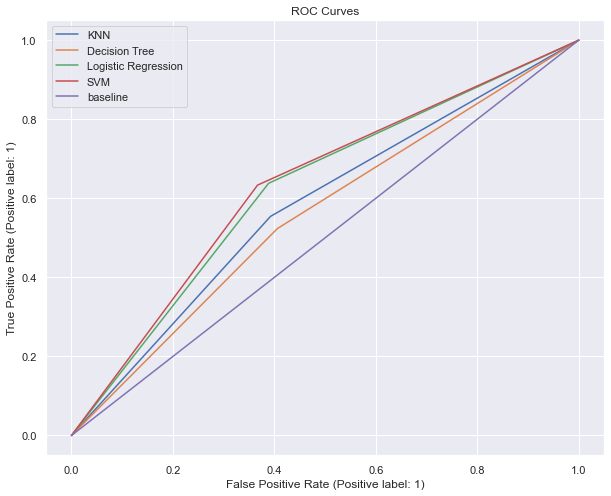

In [52]:
#Plot ROC Curves for all models
fig, ax = plt.subplots(figsize=(10,8))
RocCurveDisplay.from_predictions(knn_pipe.predict( X_test), y_test, pos_label = 1, ax = ax, label = 'KNN')
RocCurveDisplay.from_predictions(dt_pipe.predict(X_test), y_test, pos_label = 1, ax = ax, label = 'Decision Tree')
RocCurveDisplay.from_predictions(lr_pipe.predict(X_test), y_test, pos_label = 1, ax = ax, label = 'Logistic Regression')
RocCurveDisplay.from_predictions(svc_pipe.predict(X_test), y_test, pos_label = 1, ax = ax, label = 'SVM')
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)

### Confusion Matrices

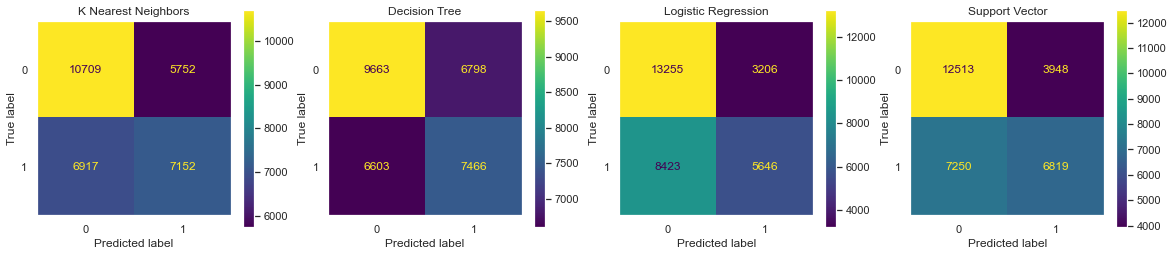

In [53]:
# plot confusion matrices
fig, ax = plt.subplots(1, 4, figsize = (20, 4))
ConfusionMatrixDisplay.from_estimator(knn_pipe, X_test, y_test, ax = ax[0])
ConfusionMatrixDisplay.from_estimator(dt_pipe, X_test, y_test, ax = ax[1])
ConfusionMatrixDisplay.from_estimator(lr_pipe, X_test, y_test, ax = ax[2])
ConfusionMatrixDisplay.from_estimator(svc_pipe, X_test, y_test, ax = ax[3])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)
ax[0].set_title('K Nearest Neighbors')
ax[1].set_title('Decision Tree')
ax[2].set_title('Logistic Regression')
ax[3].set_title('Support Vector')
plt.show()

### Summary

Comparing the four models with default parameters, we can see that KNN is the fastest followed by Logistic Regression and Decision Tree. The Support Vector took a really long time compared to the other three models. 
In terms of accuracy, Support Vector was the most accurate followed closely by Logistic Regression. Decision Tree had the lowest test accuracy. All models did better than our baseline model.
With default parameters, we would recommend the logistic regression for this classification problem in terms of overall performance (second in both test accuracy and performance time).

## Feature Engineering

### Examine Permutation Importance in our Logistic Regression Model

In [54]:
#Examine permutation importance of the factors

# score with test set
print('model accuracy :', lr_pipe.score(X_test, y_test))
# permutation importance
r = permutation_importance(lr_pipe, X_test, y_test, n_repeats = 50, random_state = 93)
print('importance:', r.importances_mean)
pd.DataFrame({"Column":X.columns, "Importance":r.importances_mean}).sort_values(
        by = "Importance", ascending = False)

model accuracy : 0.6190959711758925
importance: [6.62299378e-04 1.32787422e-03 5.43727481e-05 5.76482149e-04
 1.78578447e-03 7.67114314e-04 1.26629545e-03 1.05207992e-03
 2.50769735e-03 3.73403210e-04 4.99705208e-03 7.92531936e-03
 6.33324599e-02 4.67605634e-03 6.16442843e-04 3.73403210e-05
 3.66852276e-04 1.18637406e-03]


,Column,Importance
12,number_inpatient,0.063332
11,number_emergency,0.007925
10,number_outpatient,0.004997
13,number_diagnoses,0.004676
8,num_procedures,0.002508
4,discharge_disposition_id,0.001786
1,gender,0.001328
6,time_in_hospital,0.001266
17,diabetesMed,0.001186
7,num_lab_procedures,0.001052


We can clearly see that number of hospital visits (inpatient) is the most important feature in predicting if a patient will be readmitted.That's followed by number of Emergency (ED visits), number of outpatient clinic visits, number of diagnoses and number of procedures. Also based on the distributions by age and gender charts above, it makes sense that gender is important but age is not.

##### Examine effect of removing features with low permutation importance (<0.0005)

In [55]:
X_train2 = X_train.drop(['num_medications','change','age','A1Cresult'], axis = 1)
X_test2 = X_test.drop(['num_medications','change','age','A1Cresult'], axis = 1)

In [56]:
#Using logistic regression  as it was the best perfroming model so far with defaults
lr_start2 = process_time()
lr_pipe2 = Pipeline([('transform', StandardScaler()), ('lr', LogisticRegression())])
lr_pipe2.fit(X_train2, y_train)
lr_stop2 = process_time()
lr_pipe2

Pipeline(steps=[('transform', StandardScaler()), ('lr', LogisticRegression())])

In [57]:
lr_train_acc2 = lr_pipe2.score(X_train2, y_train)
lr_test_acc2 = lr_pipe2.score(X_test2, y_test)
lr_predictions2 = lr_pipe2.predict(X_test2)
lr_time2= lr_stop2-lr_start2

### Results
print(classification_report(lr_predictions2, y_test))

print(f'Training Accuracy : {lr_train_acc2: .2f}')
print(f'Test Accuracy     : {lr_test_acc2: .8f}')
print(f'Train Time        : {lr_time2}')

              precision    recall  f1-score   support

           0       0.81      0.61      0.70     21726
           1       0.40      0.64      0.49      8804

    accuracy                           0.62     30530
   macro avg       0.60      0.62      0.59     30530
weighted avg       0.69      0.62      0.64     30530

Training Accuracy :  0.62
Test Accuracy     :  0.61870292
Train Time        : 0.296875


We see that the test accuracy drops ever so slightly after the removal of these 4 features from 61.90 to 61.87 but the training time improves by 40% (0.35 to 0.20). Also, we will keep these features for now but we can consider dropping them without losing much in our model if we encounter perfromance issues further.

### Find Best Logistic Regression Using Grid Search CV

In [58]:
lr_params = {'lr__C': np.logspace(-3,3,7),
         'lr__penalty': ["l1","l2"]    # l1 lasso l2 ridge
         }

#### Grid Search with model using default scoring

In [59]:
#Grid Search with model using default scoring
lr_grid_def = GridSearchCV(lr_pipe, param_grid = lr_params)
lr_grid_def.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'lr__penalty': ['l1', 'l2']})

In [60]:
lr_train_acc_g_def = lr_grid_def.score(X_train, y_train)
lr_test_acc_g_def = lr_grid_def.score(X_test, y_test)
lr_best_params_g_def = lr_grid_def.best_params_
lr_predictions_g_def = lr_grid_def.predict(X_test)

### Results
print(classification_report(lr_predictions_g_def, y_test))

print(f'Train Accuracy: {lr_train_acc_g_def: .2f}')
print(f'Test Accuracy    : {lr_test_acc_g_def: .8f}')
print(f'Train Time: {np.sum(lr_grid_def.cv_results_["mean_fit_time"])}')
print(f'Best parameters: {lr_best_params_g_def}')

              precision    recall  f1-score   support

           0       0.81      0.61      0.70     21678
           1       0.40      0.64      0.49      8852

    accuracy                           0.62     30530
   macro avg       0.60      0.62      0.59     30530
weighted avg       0.69      0.62      0.64     30530

Train Accuracy:  0.62
Test Accuracy    :  0.61909597
Train Time: 0.6796035766601562
Best parameters: {'lr__C': 10.0, 'lr__penalty': 'l2'}


#### Grid Search with model using "roc_auc" scoring

In [61]:
lr_grid = GridSearchCV(lr_pipe, param_grid = lr_params, scoring='roc_auc')
lr_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'lr__penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [62]:
lr_train_acc_g = lr_grid.score(X_train, y_train)
lr_test_acc_g = lr_grid.score(X_test, y_test)
lr_best_params_g = lr_grid.best_params_
lr_predictions_g = lr_grid.predict(X_test)

### Results
print(classification_report(lr_predictions_g, y_test))

print(f'Train Accuracy: {lr_train_acc_g: .2f}')
print(f'Test Accuracy    : {lr_test_acc_g: .8f}')
print(f'Train Time: {np.sum(lr_grid.cv_results_["mean_fit_time"])}')
print(f'Best parameters: {lr_best_params_g}')

              precision    recall  f1-score   support

           0       0.81      0.61      0.70     21678
           1       0.40      0.64      0.49      8852

    accuracy                           0.62     30530
   macro avg       0.60      0.62      0.59     30530
weighted avg       0.69      0.62      0.64     30530

Train Accuracy:  0.65
Test Accuracy    :  0.65397841
Train Time: 0.7401769638061523
Best parameters: {'lr__C': 100.0, 'lr__penalty': 'l2'}


We will be using the "roc_auc" scoring as the data is balanced and it improves our test accuracy.

### Find Best KNN Classifier Using Grid Search CV

In [63]:
knn_params = {'knn__n_neighbors': range(1, 51, 2), 'knn__weights':['uniform', 'distance']} 
knn_grid = GridSearchCV(knn_pipe, param_grid = knn_params , scoring='roc_auc')
knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(1, 51, 2),
                         'knn__weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [64]:
knn_train_acc_g = knn_grid.score(X_train, y_train)
knn_test_acc_g = knn_grid.score(X_test, y_test)
knn_best_params_g = knn_grid.best_params_
knn_predictions_g = knn_grid.predict(X_test)

### Results
print(classification_report(knn_predictions_g, y_test))

print(f'Train Accuracy: {knn_train_acc_g: .2f}')
print(f'Test Accuracy    : {knn_test_acc_g: .8f}')
print(f'Train Time: {np.sum(knn_grid.cv_results_["mean_fit_time"])}')
print(f'Best parameters: {knn_best_params_g}')

              precision    recall  f1-score   support

           0       0.75      0.61      0.68     20185
           1       0.45      0.61      0.51     10345

    accuracy                           0.61     30530
   macro avg       0.60      0.61      0.59     30530
weighted avg       0.65      0.61      0.62     30530

Train Accuracy:  1.00
Test Accuracy    :  0.65281605
Train Time: 3.1219990730285643
Best parameters: {'knn__n_neighbors': 49, 'knn__weights': 'distance'}


### Find Best Decision Tree Using Grid Search CV

In [65]:
dt_params = {'dt__max_depth': [i for i in range(1, 11)],
         'dt__min_samples_split': [0.05,0.1, 0.2],
          'dt__criterion': ['gini', 'entropy'],
          'dt__min_samples_leaf': [2, 5]
         }
dt_grid = GridSearchCV(dt_pipe, param_grid = dt_params, scoring='roc_auc')
dt_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', StandardScaler()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'dt__min_samples_leaf': [2, 5],
                         'dt__min_samples_split': [0.05, 0.1, 0.2]},
             scoring='roc_auc')

In [66]:
dt_train_acc_g = dt_grid.score(X_train, y_train)
dt_test_acc_g = dt_grid.score(X_test, y_test)
dt_best_params_g = dt_grid.best_params_
dt_predictions_g = dt_grid.predict(X_test)

### Results
print(classification_report(dt_predictions_g, y_test))

print(f'Train Accuracy: {dt_train_acc_g: .2f}')
print(f'Test Accuracy    : {dt_test_acc_g: .8f}')
print(f'Train Time: {np.sum(dt_grid.cv_results_["mean_fit_time"])}')
print(f'Best parameters: {dt_best_params_g}')

              precision    recall  f1-score   support

           0       0.75      0.63      0.69     19588
           1       0.49      0.63      0.55     10942

    accuracy                           0.63     30530
   macro avg       0.62      0.63      0.62     30530
weighted avg       0.66      0.63      0.64     30530

Train Accuracy:  0.67
Test Accuracy    :  0.66508313
Train Time: 11.263421678543091
Best parameters: {'dt__criterion': 'gini', 'dt__max_depth': 8, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 0.05}


### Find Best SVM Using Grid Search CV / Randomized Search CV (faster but less accurate)

Note: Can be run on faster performing machines in the future to improve the SVC model by adjusting parameters.

##### Set parmas

In [67]:
#svc_params = [
#    {"svc__kernel": ["linear"], "svc__gamma": [0.1, 1, 10, 100, 1000]},
#    {"svc__kernel": ["poly"], "svc__degree": [2, 3], "svc__gamma": [0.1, 1, 10, 100, 1000]},
#    {"svc__kernel": ["rbf"], "svc__gamma": [0.1, 1, 10, 100, 1000]},
#]

In [68]:
#Alternative : Running with fewer parameters for better performance because of machine limitation
#svc_params = [
#    {"svc__kernel": ["linear"], "svc__gamma": [0.1, 1, 10]},
#    {"svc__kernel": ["poly"], "svc__degree": [2], "svc__gamma": [0.1, 1, 10]},
#    {"svc__kernel": ["rbf"], "svc__gamma": [0.1, 1, 10]},
#]

##### Grid Search CV

In [69]:
#svc_grid = GridSearchCV(svc_pipe, param_grid = svc_params, scoring='roc_auc')
#svc_grid.fit(X_train, y_train)

##### Randomized Search CV (Faster alternate)

In [70]:
#Use Randomized Search CV with fewer iterations to improve performance becasue GridSearch CV could not run and took for ever
# (ideally we'd choose n_iter of 100)

#Method 1: More defaults 
#svc_grid = RandomizedSearchCV(svc_pipe, param_distributions=svc_params)

#Alternative Method 2: More paremters selected
#svc_grid = RandomizedSearchCV(svc_pipe, param_distributions=svc_params, n_iter = 20, n_jobs = 4, cv = 3, scoring='roc_auc')
#svc_grid.fit(X_train, y_train)

##### SVC Grid Results

In [88]:
#svc_train_acc_g = svc_grid.score(X_train, y_train)
#svc_test_acc_g = svc_grid.score(X_test, y_test)
#svc_best_params_g= svc_grid.best_params_
#svc_predictions_g = svc_grid.predict(X_test)

### Results
#print(classification_report(lr_predictions_g, y_test))

#print(f'Train Accuracy: {svc_train_acc_g: .2f}')
#print(f'Test Accuracy    : {svc_test_acc_g: .8f}')
#print(f'Train Time: {np.sum(svc_grid.cv_results_["mean_fit_time"])}')
#print(f'Best parameters: {svc_best_params_g}')

### Results Dataframe - From Grid Search

In [72]:
# Results Dataframe: - Can include SVM results in future with better performing systems

results_df_g = pd.DataFrame({'KNN':pd.Series(knn_best_params_g),
                         'Decision Tree':pd.Series(dt_best_params_g),
                         'Logistic Regression':pd.Series(lr_best_params_g) #,
                         #'Support Vector':pd.Series(svc_best_params_g)
                        })

results_df_g.loc['Train Accuracy', :] =  [knn_train_acc_g, dt_train_acc_g,lr_train_acc_g] #, svc_train_acc_g]
results_df_g.loc['Test Accuracy', :] =  [knn_test_acc_g, dt_test_acc_g,lr_test_acc_g] #, svc_test_acc_g]
results_df_g.loc['Train Time', :] = [np.sum(knn_grid.cv_results_['mean_fit_time']),
                                      np.sum(dt_grid.cv_results_['mean_fit_time']),
                                      np.sum(lr_grid.cv_results_['mean_fit_time']) #,
                                      #np.sum(svc_grid.cv_results_['mean_fit_time'])]
                                  ]

results_df_g.dropna()

,KNN,Decision Tree,Logistic Regression
Train Accuracy,1.0,0.665681,0.653698
Test Accuracy,0.652816,0.665083,0.653978
Train Time,3.121999,11.263422,0.740177


In [73]:
results_df_g #Including best parameters for each model

,KNN,Decision Tree,Logistic Regression
dt__criterion,NaN,gini,NaN
dt__max_depth,NaN,8,NaN
dt__min_samples_leaf,NaN,2,NaN
dt__min_samples_split,NaN,0.05,NaN
knn__n_neighbors,49,NaN,NaN
knn__weights,distance,NaN,NaN
lr__C,NaN,NaN,100.0
lr__penalty,NaN,NaN,l2
Train Accuracy,1.0,0.665681,0.653698
Test Accuracy,0.652816,0.665083,0.653978


## Compare best fit for each model

### Fit best KNN classifier

In [74]:
knn_pipe_best = Pipeline([('transform', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=49, weights = 'distance'))])

In [75]:
knn_pipe_best.fit(X_train, y_train)

Pipeline(steps=[('transform', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=49, weights='distance'))])

### Fit best Decision Tree

In [76]:
dtree_pipe_best = Pipeline([('transform', StandardScaler()), ('knn', DecisionTreeClassifier(random_state=42, criterion = 'gini',
                                                                                      max_depth = 8, min_samples_leaf =2,
                                                                                      min_samples_split = 0.05))])

In [77]:
dtree_pipe_best.fit(X_train, y_train)

Pipeline(steps=[('transform', StandardScaler()),
                ('knn',
                 DecisionTreeClassifier(max_depth=8, min_samples_leaf=2,
                                        min_samples_split=0.05,
                                        random_state=42))])

### Fit best Logistic Regression

In [78]:
lr_pipe_best = Pipeline([('transform', StandardScaler()), ('lr', LogisticRegression( C= 100, penalty = 'l2'))])

In [79]:
lr_pipe_best.fit(X_train, y_train)

Pipeline(steps=[('transform', StandardScaler()),
                ('lr', LogisticRegression(C=100))])

### Fit best Support Vector (SVM)

In [80]:
#svc_pipe_best = Pipeline([('transform', StandardScaler()), ('svc', SVC(gamma=0.1, kernel='rbf'))])

In [81]:
#svc_pipe_best.fit(X_train, y_train)

## Plot Precision-Recall Curves

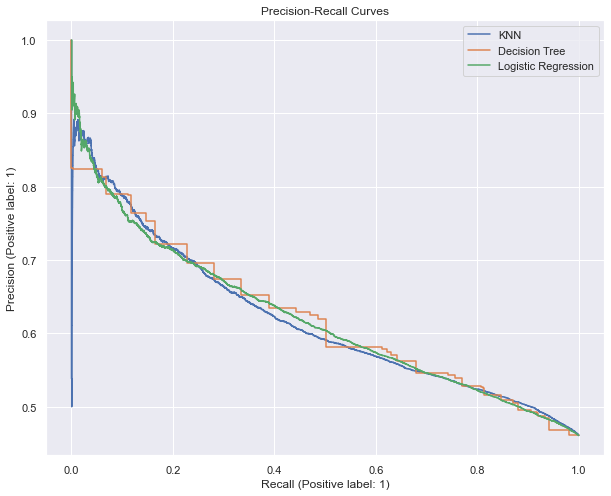

In [82]:
#Plot ROC Curves for all models
fig, ax = plt.subplots(figsize=(10,8))
PrecisionRecallDisplay.from_estimator(knn_pipe_best, X_test, y_test, pos_label = 1, ax = ax, label = 'KNN')
PrecisionRecallDisplay.from_estimator(dtree_pipe_best, X_test, y_test, pos_label = 1, ax = ax, label = 'Decision Tree')
PrecisionRecallDisplay.from_estimator(lr_pipe_best, X_test, y_test, pos_label = 1, ax = ax, label = 'Logistic Regression')
#PrecisionRecallDisplay.from_estimator(svc_pipe_best, X_test, y_test, pos_label = 1, ax = ax, label = 'SVM')
#plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)

## Plot ROC Curves

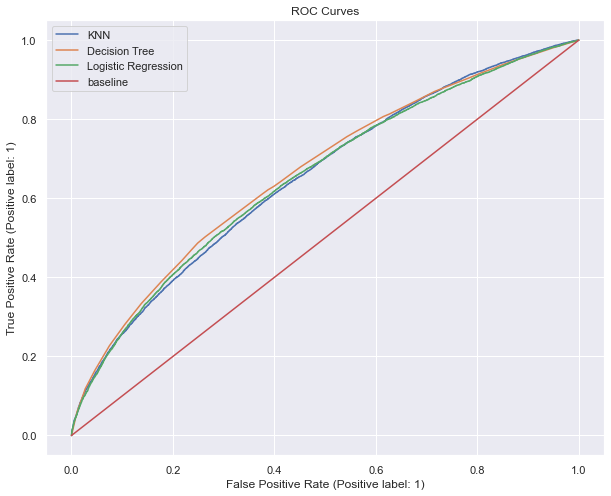

In [83]:
#Plot ROC Curves for all models
fig, ax = plt.subplots(figsize=(10,8))
RocCurveDisplay.from_estimator(knn_pipe_best, X_test, y_test, pos_label = 1, ax = ax, label = 'KNN')
RocCurveDisplay.from_estimator(dtree_pipe_best, X_test, y_test, pos_label = 1, ax = ax, label = 'Decision Tree')
RocCurveDisplay.from_estimator(lr_pipe_best, X_test, y_test, pos_label = 1, ax = ax, label = 'Logistic Regression')
#RocCurveDisplay.from_estimator(svc_pipe_best, X_test, y_test, pos_label = 1, ax = ax, label = 'SVM')
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)

## Confusion Matrices

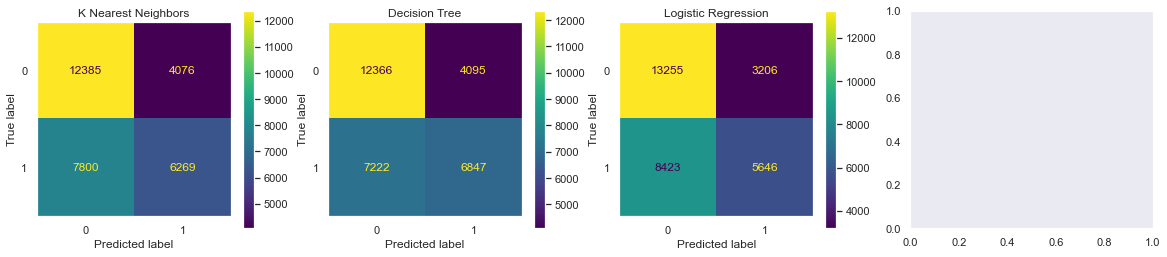

In [84]:
# plot confusion matrices
fig, ax = plt.subplots(1, 4, figsize = (20, 4))
ConfusionMatrixDisplay.from_estimator(knn_pipe_best, X_test, y_test, ax = ax[0])
ConfusionMatrixDisplay.from_estimator(dtree_pipe_best, X_test, y_test, ax = ax[1])
ConfusionMatrixDisplay.from_estimator(lr_pipe_best, X_test, y_test, ax = ax[2])
#ConfusionMatrixDisplay.from_estimator(svc_pipe_best, X_test, y_test, ax = ax[3])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)
ax[0].set_title('K Nearest Neighbors')
ax[1].set_title('Decision Tree')
ax[2].set_title('Logistic Regression')
#ax[3].set_title('Support Vector')
plt.show()

## Conclusion

In [85]:
#Results with defaults
results_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
Decision Tree,0.468750,0.999789,0.561055
KNN,0.031250,0.727203,0.585031
Logistic Regression,0.343750,0.617146,0.619096
Support Vector,419.390625,0.650135,0.633213


In [86]:
#Results after Grid Search
results_df_g.dropna()

,KNN,Decision Tree,Logistic Regression
Train Accuracy,1.0,0.665681,0.653698
Test Accuracy,0.652816,0.665083,0.653978
Train Time,3.121999,11.263422,0.740177


As we can see from the results from the Grid Search, all 3 models test accuracies improved. The logistic regression has the fastest time and the decision tree has the highest test accuracy (0.665). In terms of test accuracy logistic regression and decision tree are not far behind. Support Vector had a very long run time and it wasn't cosnidered for Grid Search CV using the available machine. 
The overall best model I would recommend in terms of both test accuracy(0.6539) and time and it's simplicity is the logistic regression model with c=100 and ridge(L2) penalty.

## Further Recommendations

In the future, I would recommend also running Grid Search CV or Randomized Search CV for the SVM model on a more performance capable device/ server.Also, we limited the data to only include the first 7 factors while creating these models. In the future, we could try to examine models that consider all factors available. We can use factor importance to pick the most important factors from them.

### Improvement Based on Further Recommendation

### Random Forest Grid Search CV

In [89]:
#Scaling is not necessary for Random Forest
rfc=RandomForestClassifier(random_state=42)

##### Set Params

In [90]:
rfc_params = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,5,10],
    'criterion' :['gini', 'entropy']
}

##### Grid Search CV

In [ ]:
rfc_grid = GridSearchCV(estimator=rfc, param_grid=rfc_params, cv= 5)
rfc_grid.fit(X_train, y_train)

##### Random Forest Grid Search CV Results

In [93]:
rfc_train_acc_g = rfc_grid.score(X_train, y_train)
rfc_test_acc_g = rfc_grid.score(X_test, y_test)
rfc_best_params_g = rfc_grid.best_params_
rfc_predictions_g = rfc_grid.predict(X_test)

### Results
print(classification_report(rfc_predictions_g, y_test))

print(f'Train Accuracy: {rfc_train_acc_g: .2f}')
print(f'Test Accuracy    : {rfc_test_acc_g: .8f}')
print(f'Train Time: {np.sum(rfc_grid.cv_results_["mean_fit_time"])}')
print(f'Best parameters: {rfc_best_params_g}')

              precision    recall  f1-score   support

           0       0.77      0.64      0.70     19864
           1       0.49      0.64      0.55     10666

    accuracy                           0.64     30530
   macro avg       0.63      0.64      0.63     30530
weighted avg       0.67      0.64      0.65     30530

Train Accuracy:  0.66
Test Accuracy    :  0.63914183
Train Time: 118.01999025344848
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}


### Fit Best Random Forest

In [95]:
rfc_best = RandomForestClassifier(random_state=42, n_estimators = 200, 
                                  max_depth=10, criterion = "gini", max_features = 'auto')

In [96]:
rfc_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=200,
                       random_state=42)

In [97]:
rfc_best_predictions = rfc_best.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(rfc_best_predictions, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,3361,1727,5088
1,2619,1358,3977
All,5980,3085,9065


In [98]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, rfc_best_predictions)))
print("Precision is {0:.2f}".format(precision_score(y_test, rfc_best_predictions)))
print("Recall is {0:.2f}".format(recall_score(y_test, rfc_best_predictions)))

Accuracy is 0.64
Precision is 0.64
Recall is 0.49


##### Feature Importance

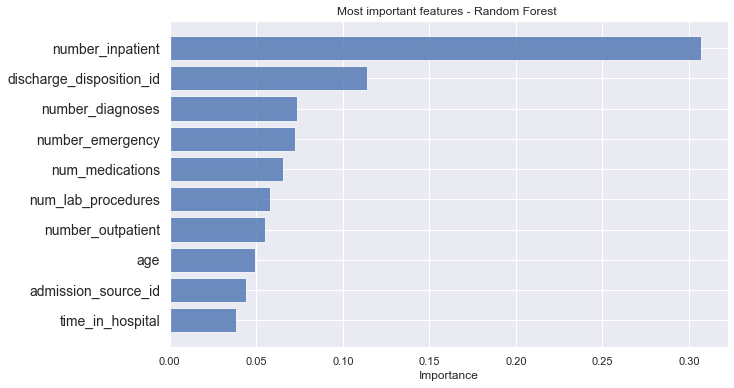

In [99]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = rfc_best.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], 
                                  columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

From the plot above, we see that number of times a patient was admitted to hospital, went to Emergency, number of diagnoses and number of medications are important features. Patient's age and how long spend in the hospital is not as important

## Revised Conclusion

After running a Grid Search CV to fine tune our Random Forest, we still see that the test accuracy(0.64) is behind that of our best Decision Tree(0.66), Logistic Regression(0.65) and KNN calssifier(0.65) models as picked by Grid Search CV.
Random Forest di not improve our model accuracy in this case.

Logistic Regression with C= 100, penalty = 'l2' is the model we would recommend as it is the fastest and is only slightly behind the best Decision Tree in terms of test accuracy.

## Additional Further Recommendations

Becasue of performance capacity limitations, we only selected a smaller subset of features for our model. In the future, expanding the Random Forest to include all or most models based on feature importance might yield better results.

## Questions